In [95]:
import numpy as np 
from matplotlib import pyplot as plt 
import math
import os

In [96]:
class PGMImage:
    def __init__(self, file_path=None):
        self.magic_number = None
        self.width = 0
        self.height = 0
        self.maxval = 0
        self.pixels = []
        self.pixels_2d = [[]]

        if file_path:
            self.mypgmread(file_path)
            self.pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))


    def mypgmread(self, file_path):
        with open(file_path, 'rb') as file:
            self.magic_number = file.readline().strip().decode('ascii')

            line = file.readline().strip()
            while line.startswith(b'#'): 
                line = file.readline().strip()

            self.width, self.height = map(int, line.split())
            self.maxval = int(file.readline().strip())
            data = file.read()
            self.pixels = list(data)

    def modify_pixels(self, row_start, row_end, new_value):
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        pixels_2d[row_start:row_end, :] = new_value
        self.pixels = pixels_2d.flatten().tolist()

    def mypgmwrite(self, filename):
        pixel_array = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))

        with open(filename, 'wb') as file:
            file.write(f"{self.magic_number}\n".encode())
            file.write(f"{self.width} {self.height}\n".encode())
            file.write(f"{self.maxval}\n".encode())
            pixel_array.tofile(file)


####################################################################################################################################################
############################## LAB-03 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    # 2D Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Dfft(self, image=None, point_m = None, point_n = None):
        if image is None:
            image = self.pixels_2d  # Varsayılan olarak sınıfın görüntüsünü kullanır
        
        # Giriş görüntüsünün boyutlarını al
        height, width = image.shape
        if point_m == None:
            point_m = height
        if point_n == None:
            point_n = width
        # Fourier Dönüşümü sonucunu tutacak karmaşık (complex) dizi oluştur
        fourier_array = np.zeros(shape = (point_m, point_n), dtype=complex)
        # Satır bazında 1D FFT uygulanır
        for i in range(height):
            fourier_array[i] = np.fft.fft(image[i], n = point_n)
        
        # Sütun bazında 1D FFT uygulanır
        for k in range(point_n):
            fourier_array[:, k] = np.fft.fft(fourier_array[:, k], n = point_m)
        
        return fourier_array

# Ortalanmış Fourier dönüşüm maskesi uygulayan fonksiyon
    def centered_fourier(self):
        centered_mask = np.zeros((self.height, self.width), dtype=complex)
        for x in range(0 , self.height):
            for y in range(0 , self.width):
                centered_mask[x][y] = (-1)**(x + y)

        return centered_mask * self.pixels_2d


# 2D Ters Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Difft(self, image = None, point_m = None, point_n = None):
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass    
        
        conj_input = np.conj(image)     # Giriş görüntüsünün konjugesini al
        conj_output = self.my2Dfft(conj_input, point_m, point_n) # konjugesi alınmış görüntünün fourier transformunu al
        inverse_conj_output = conj_output / (self.height * self.width) # Çıktıyı satır*sütun değerine böl
        inverse_image = np.conj(inverse_conj_output) # çıkış değerinin de konjugesi alınır ve original image elde edilir.

        return inverse_image

800 500
3 3
802 502
804 504


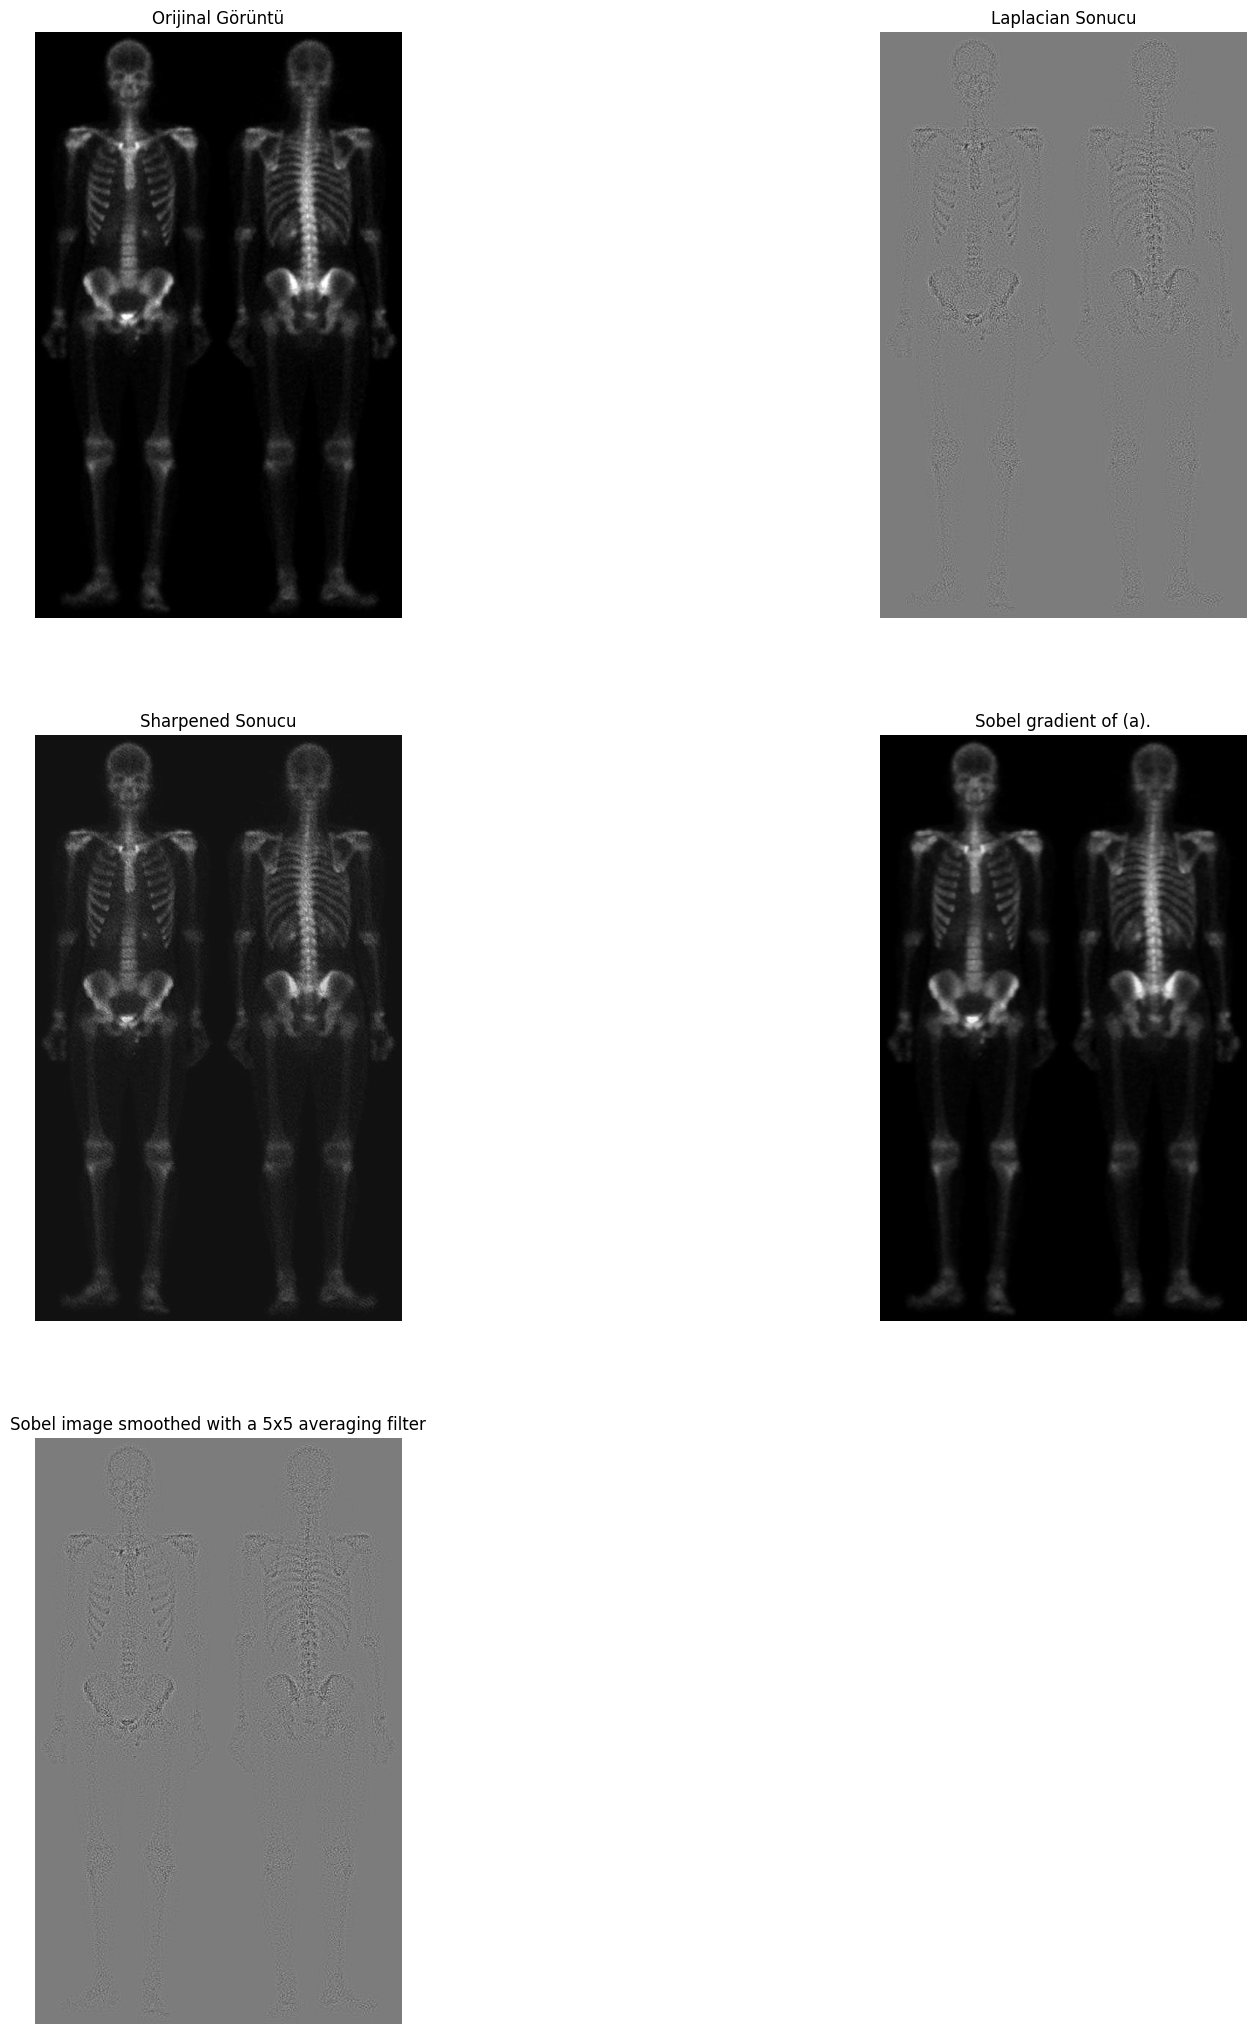

In [ ]:
image = PGMImage('Fig0343(a)(skeleton_orig).pgm')
kernel = np.array([[0, 1, 0], 
                   [1, -4, 1], 
                   [0, 1, 0]])

        
image.width
image.height 
MK, NK = kernel.shape

print(image.height, image.width)
print(MK, NK)

m_point = image.height + MK - 1
n_point = image.width + NK - 1 

pad_shape = (image.height + MK - 1, image.width + NK - 1 )
kernel_padded = np.zeros(pad_shape)
kernel_padded[:MK, :NK] = kernel

MK1, NK1 = kernel_padded.shape
print(MK1, NK1)

F_image = image.my2Dfft(image.pixels_2d, m_point, n_point)

F_kernel = image.my2Dfft(kernel_padded, m_point, n_point)

# Kernel ve Görüntü'nün frekans alanındaki çarpımı
F_result = F_image * F_kernel

# Ters Fourier dönüşümü ile sonuç görüntüsünü elde et
result = image.my2Difft(F_result, m_point, n_point)
result_real = np.real(result)

###########################################################

F_laplacian = F_image + (-1)*F_result
lap_result = image.my2Difft(F_laplacian)
lap_result_real = np.real(lap_result)

###########################################################
sobel_x = np.array( [[-1,-2,-1],
                    [0, 0, 0],
                    [1, 2, 1]])

sobel_y = np.array( [[-1, 0,-1],
                    [-2, 0, -2],
                    [-1, 0, -1]])

sobel_x_padded = np.zeros(pad_shape)
sobel_x_padded[:MK, :NK] = sobel_x

sobel_y_padded = np.zeros(pad_shape)
sobel_y_padded[:MK, :NK] = sobel_y

F_sobel_X = image.my2Dfft(sobel_x_padded,m_point, n_point)
F_sobel_Y = image.my2Dfft(sobel_y_padded,m_point, n_point)

F_x_result = F_image * F_sobel_X
F_y_result = F_image * F_sobel_Y

gx = image.my2Difft(F_x_result, m_point, n_point)
gy = image.my2Difft(F_y_result, m_point, n_point)

g = np.abs(gx) + np.abs(gy)
###########################################################
average_filter = np.array( [[1,1,1,1,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1],
                            [1,1,1,1,1]])
MA, NA = average_filter.shape

pad_shape_avg = (image.height + MA - 1, image.width + NA - 1 )
average_filter_padded = np.zeros(pad_shape_avg)
average_filter_padded[:MA, :NA] = average_filter

m_point_avg = image.height + MA - 1
n_point_avg = image.width + NA - 1 

F_average_filter = image.my2Dfft(average_filter_padded, m_point_avg, n_point_avg)
F_g = image.my2Dfft(g, m_point_avg, n_point_avg)

F_avg_result = F_g * F_average_filter

avg_result = image.my2Difft(F_avg_result, m_point_avg, n_point_avg)
avg_result_real = np.real(avg_result)

###########################################################

plt.figure(figsize=(20, 35))

plt.subplot(4, 2, 1)
plt.title("Orijinal Görüntü")
plt.axis('off')
plt.imshow(image.pixels_2d, cmap="gray")

plt.subplot(4, 2, 2)
plt.title("Laplacian Sonucu")
plt.axis('off')
plt.imshow(result_real, cmap="gray")

plt.subplot(4, 2, 3)
plt.title("Sharpened Sonucu")
plt.axis('off')
plt.imshow(lap_result_real, cmap="gray")

plt.subplot(4, 2, 4)
plt.title("Sobel gradient of (a).")
plt.axis('off')
plt.imshow(g, cmap="gray")

plt.subplot(4, 2, 5)
plt.title("Sobel image smoothed with a 5x5 averaging filter")
plt.axis('off')
plt.imshow(avg_result_real, cmap="gray")

plt.show()
